In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from mvlearn.ajive.ajive import ajive
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\arman\Anaconda3\envs\mvdev\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\arman\Anaconda3\envs\mvdev\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Angle-based Joint and Individual Variation Explained

JIVE is a useful algorithm that decomposes multiple views of data into three main categories:
    - Joint Variation
    - Individual Variation
    - Noise
This notebook will prove out the implementation of JIVE and show some examples of the algorithm's usefulness

## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:
<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

The two views are created with a shared joint variation, unique individual variation, and a noise matrix. A representation of what the implementation of this algorithm does can be seen in the cell below.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0047259X1730204X-gr1.jpg">


In [3]:
np.random.seed(12)

# First View
V1_joint = np.bmat([[-1 * np.ones((50, 2000))],
                       [np.ones((50, 2000))]])

V1_joint = np.bmat([np.zeros((100, 8000)), V1_joint])

V1_indiv_t = np.bmat([[np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))],
                        [np.zeros((20, 5000))],
                        [np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))]])

V1_indiv_b = np.bmat([[np.ones((25, 5000))],
                        [-1 * np.ones((50, 5000))],
                        [np.ones((25, 5000))]])

V1_indiv_tot = np.bmat([V1_indiv_t, V1_indiv_t])

V1_noise = np.random.normal(loc=0, scale=1, size=(100, 10000))


# Second View
V2_joint = np.bmat([[np.ones((50, 50))],
                      [-1*np.ones((50, 50))]])

V2_joint = 5000 * np.bmat([V2_joint, np.zeros((100, 50))])

V2_indiv = 5000 * np.bmat([[-1 * np.ones((25, 100))],
                              [np.ones((25, 100))],
                              [-1 * np.ones((25, 100))],
                              [np.ones((25, 100))]])

V2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(100, 100))

# View Construction

V1 = V1_indiv_tot + V1_joint + V1_noise

V2 = V2_indiv + V2_joint + V2_noise

Views_1 = [V1, V1]
Views_2 = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view

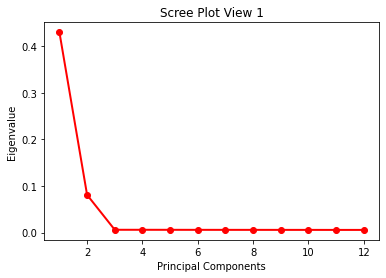

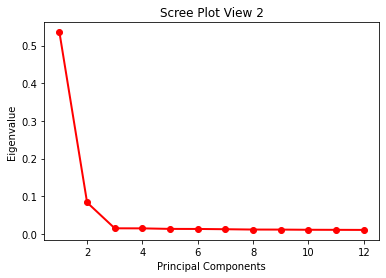

<Figure size 432x288 with 0 Axes>

In [4]:
def scree_plot(n,V,name):
    U, S, V = np.linalg.svd(V)
    eigvals = S**2 / np.sum(S**2)
    eigval_terms = np.arange(n) + 1
    plt.plot(eigval_terms, eigvals[0:n], 'ro-', linewidth=2)
    plt.title('Scree Plot '+ name)
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.figure()

scree_plot(12,V1,'View 1')
scree_plot(12,V2,'View 2')

#It seems as though both inital ranks can be set to 3

In [5]:
#Fitting ajive

ajive1 = ajive(init_signal_ranks= [2,2])
ajive1.fit(blocks=[V1,V1])

ajive2 = ajive(init_signal_ranks= [2,2])
ajive2.fit(blocks=[V1,V2])



joint rank: 1, block 0 indiv rank: 1, block 1 indiv rank: 1

## Output Structure

The get_full_block_estimates() function returns n dictionaries where n is the number of views that fitted. Each dictionary has a joint, individual, and noise matrix taken from the AJIVE decomposition. The keys are 'joint', 'individual', and 'noise' and the values are the respective matrices.


In [8]:
blocks1 = ajive1.predict()
blocks2 = ajive2.predict()


## Heatmap Visualization

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm creates new decompositions that can be seen two cells below

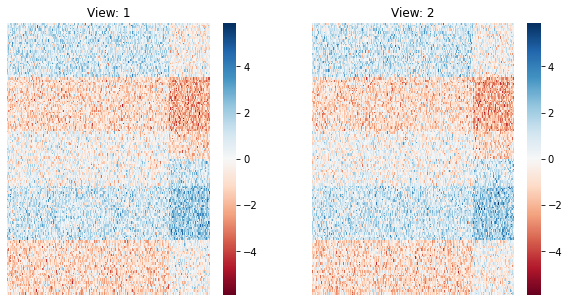

In [41]:
plt.figure(figsize=[10, 5])
ajive.data_block_heatmaps(Views_1)

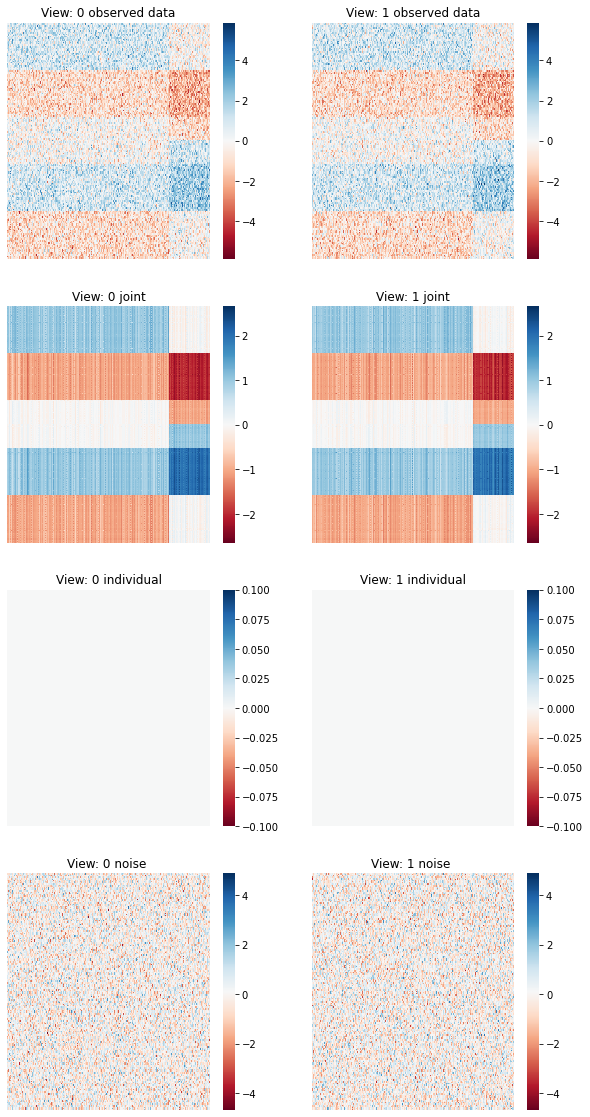

In [44]:
plt.figure(figsize=[10, 20])
ajive.ajive_full_estimate_heatmaps(blocks1, Views_1)

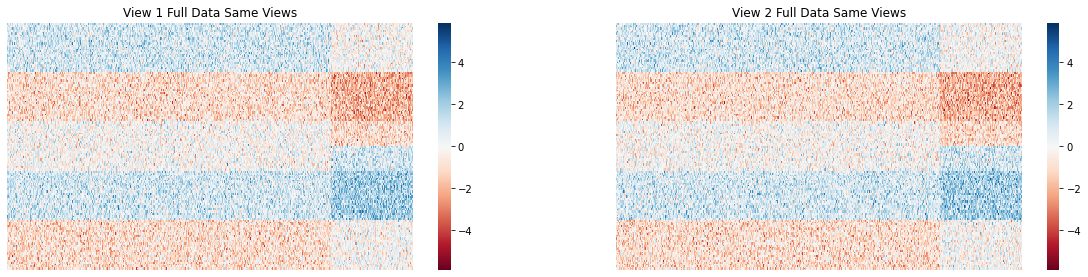

<Figure size 1440x720 with 0 Axes>

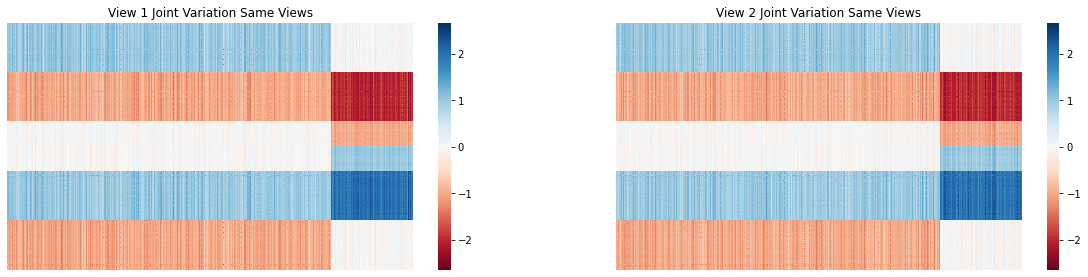

<Figure size 1440x720 with 0 Axes>

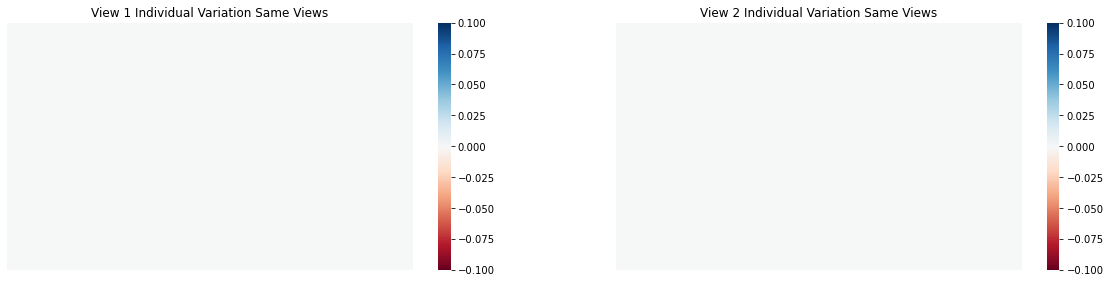

<Figure size 1440x720 with 0 Axes>

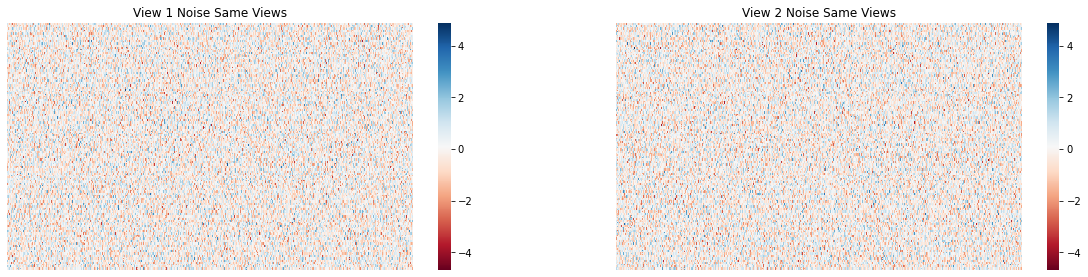

<Figure size 1440x720 with 0 Axes>

In [13]:
def heatmaps(string,inp):
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    sns.heatmap(inp[0], xticklabels = False, yticklabels = False, cmap = 'RdBu')
    plt.title('View 1 ' + string)
    plt.subplot(2,2,2)
    sns.heatmap(inp[1], xticklabels = False, yticklabels = False, cmap = 'RdBu')
    plt.title('View 2 ' + string)
    plt.figure(figsize=(20,10))

heatmaps("Full Data Same Views", Views_1)

Joint = [blocks1[0]['joint'],blocks1[1]['joint']]
heatmaps("Joint Variation Same Views", Joint)

Individual = [blocks1[0]['individual'],blocks1[1]['individual']]
heatmaps("Individual Variation Same Views", Individual)

Noise = [blocks1[0]['noise'],blocks1[1]['noise']]
heatmaps("Noise Same Views", Noise)

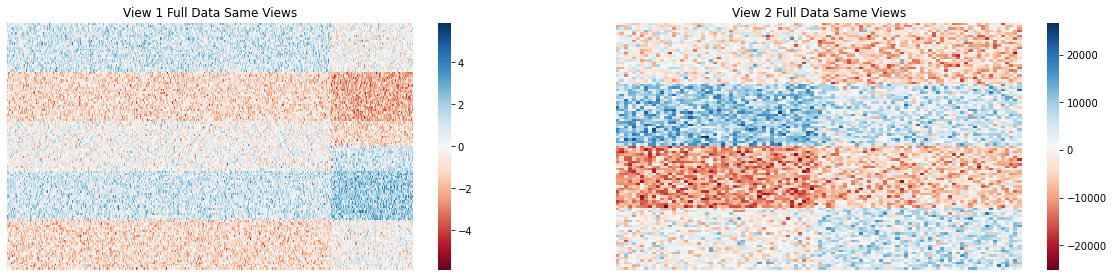

<Figure size 1440x720 with 0 Axes>

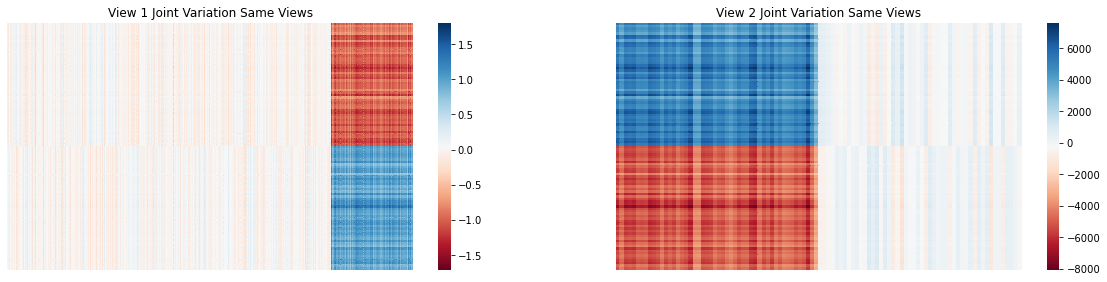

<Figure size 1440x720 with 0 Axes>

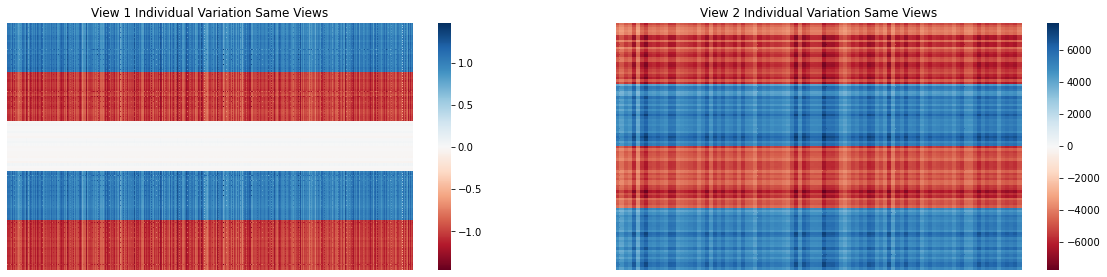

<Figure size 1440x720 with 0 Axes>

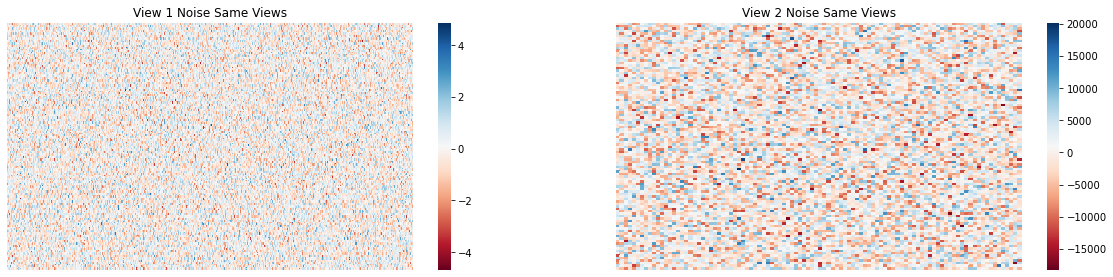

<Figure size 1440x720 with 0 Axes>

In [14]:
heatmaps("Full Data Same Views", Views_2)

Joint = [blocks2[0]['joint'],blocks2[1]['joint']]
heatmaps("Joint Variation Same Views", Joint)

Individual = [blocks2[0]['individual'],blocks2[1]['individual']]
heatmaps("Individual Variation Same Views", Individual)

Noise = [blocks2[0]['noise'],blocks2[1]['noise']]
heatmaps("Noise Same Views", Noise)